<a href="https://colab.research.google.com/github/colawhite/spark_ml/blob/master/spark_logistic_reg_first_mdl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import files
uploaded = files.upload()

Saving datasets_520_1034_bank.csv to datasets_520_1034_bank.csv


In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.6/spark-2.4.6-bin-hadoop2.6.tgz    
!tar xf spark-2.4.6-bin-hadoop2.6.tgz    
!pip install -q findspark

In [79]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.6-bin-hadoop2.6"

In [80]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
from pyspark.ml.classification import LogisticRegression

In [81]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df = spark.read.csv('datasets_520_1034_bank.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [82]:
import pandas as pd

In [83]:
df.take(5)

[Row(age=59, job='admin.', marital='married', education='secondary', default='no', balance=2343, housing='yes', loan='no', contact='unknown', day=5, month='may', duration=1042, campaign=1, pdays=-1, previous=0, poutcome='unknown', deposit='yes'),
 Row(age=56, job='admin.', marital='married', education='secondary', default='no', balance=45, housing='no', loan='no', contact='unknown', day=5, month='may', duration=1467, campaign=1, pdays=-1, previous=0, poutcome='unknown', deposit='yes'),
 Row(age=41, job='technician', marital='married', education='secondary', default='no', balance=1270, housing='yes', loan='no', contact='unknown', day=5, month='may', duration=1389, campaign=1, pdays=-1, previous=0, poutcome='unknown', deposit='yes'),
 Row(age=55, job='services', marital='married', education='secondary', default='no', balance=2476, housing='yes', loan='no', contact='unknown', day=5, month='may', duration=579, campaign=1, pdays=-1, previous=0, poutcome='unknown', deposit='yes'),
 Row(age=5

In [84]:
df.head()

Row(age=59, job='admin.', marital='married', education='secondary', default='no', balance=2343, housing='yes', loan='no', contact='unknown', day=5, month='may', duration=1042, campaign=1, pdays=-1, previous=0, poutcome='unknown', deposit='yes')

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

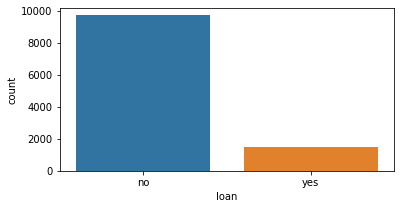

In [86]:
plt.figure(figsize=(6,3))
sns.countplot(x='loan', data=df.toPandas())

In [87]:
cat_cols = [item[0] for item in df.dtypes if item[1].startswith('string')] 
print(str(len(cat_cols)) + '  categorical features')
print(cat_cols)
num_cols = [item[0] for item in df.dtypes if item[1].startswith('int') | item[1].startswith('double')][1:]
print(str(len(num_cols)) + '  numerical features')
print(num_cols)

10  categorical features
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']
6  numerical features
['balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


Check nulls

In [88]:
# convert to pandas for null calculation
df.toPandas().isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

Feature engineering - OneHotEncoding

In [89]:
cat_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'deposit']

In [90]:
if 'loan' in cat_cols: cat_cols.remove('loan')
stages = []
for col in cat_cols:
    stringIndexer = StringIndexer(inputCol = col, outputCol = col + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[col + "classVec"])
    stages += [stringIndexer, encoder]
assemblerInputs = [c + "classVec" for c in cat_cols] + num_cols
assemblerInputs
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

Feature engineering - pipeline

In [91]:
cols = df.columns
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(df)
new_df = pipelineModel.transform(df)
selectedCols = ['features']+cols
new_df = new_df.select(selectedCols)
new_df.show(5)
new_df=new_df.withColumn('label', F.when(F.col('loan')=='yes', 1).otherwise(0))
new_df.show(5)
#pd.DataFrame(new_df.take(5))

+--------------------+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|            features|age|       job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+--------------------+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|(41,[3,11,13,16,1...| 59|    admin.|married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
|(41,[3,11,13,16,1...| 56|    admin.|married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
|(41,[2,11,13,16,1...| 41|technician|married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
|(41,[4,11,13,16,1...| 55|  services|married|secondary|     no|   2476|    yes|  n

In [92]:
train, test = new_df.randomSplit([0.80, 0.20], seed = 42)
print(train.count())
print(test.count())

8960
2202


In [93]:
LR = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=15)
LR_model = LR.fit(train)

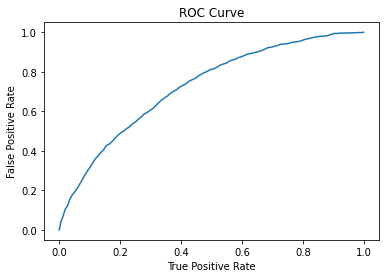

Training set ROC: 0.7246918624629768


In [94]:
#plotting the ROC Curve
trainingSummary = LR_model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set ROC: ' + str(trainingSummary.areaUnderROC))

In [95]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
predictions_LR = LR_model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(predictions_LR, {evaluator.metricName: "areaUnderROC"})))

Test_SET (Area Under ROC): 0.7158377732377287


In [96]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=15)
GBT_Model = gbt.fit(train)
gbt_predictions = GBT_Model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(gbt_predictions, {evaluator.metricName: "areaUnderROC"})))

Test_SET (Area Under ROC): 0.7262306547022899
